Reconhecimento de Padrões

Lista 2: Regressão Polinomial

# Imports

In [244]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.datasets import load_iris

In [245]:
breast = pd.read_csv("content/breast.csv", header=None)
print(breast.shape)
breast.head()

(569, 31)


,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0


In [246]:
iris = load_iris()
df_iris = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df_iris['target'] = iris.target
df_iris = df_iris.iloc[:, 2:]
df_iris.head()

,petal length (cm),petal width (cm),target
0,1.4,0.2,0
1,1.4,0.2,0
2,1.3,0.2,0
3,1.5,0.2,0
4,1.4,0.2,0


# Models

In [247]:
class GradientDescent:
    def __init__(self, alpha=0.1, epochs=10):
        self.alpha = alpha
        self.epochs = epochs
        self.w = []
        self.mse_per_epoch = []

    def fit(self, x, y, plot=False):
        x = x.copy()
        x.insert(0, "x0", 1)
        x = x.values

        self.w = np.zeros(x.shape[1])

        for epoch in range(self.epochs):
            error_list = []
            mse = 0

            for i in range(len(x)):
                y_hat = x[i] @ self.w
                error = y[i] - y_hat
                error_list.append(error * x[i])
                mse += error**2

            self.w += self.alpha * 1 / len(x) * sum(error_list)
            self.mse_per_epoch.append(mse / (2 * len(x)))

        return self.w

    def predict(self, x):
        x = x.copy()
        x.insert(0, "x0", 1)
        x = x.values

        return x @ self.w

In [248]:
class GradientDescentClassificator:
    def __init__(self, alpha=0.1, epochs=10, threshold=0.5):
        self.alpha = alpha
        self.epochs = epochs
        self.w = []
        self.cost_per_epoch = []
        self.threshold = threshold

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def fit(self, x, y, plot=False):
        x = x.copy()
        x.insert(0, "x0", 1)
        x = x.values

        self.w = np.zeros(x.shape[1])

        for epoch in range(self.epochs):
            error_list = []
            cost = 0
            for i in range(len(x)):
                y_hat = self.sigmoid(x[i] @ self.w)
                error = y[i] - y_hat
                error_list.append(error * x[i])
                cost += y[i] * np.log(y_hat) + (1 - y[i]) * np.log(1 - y_hat)

            self.w += self.alpha * sum(error_list) / len(x)
            self.cost_per_epoch.append(-cost / len(x))

        return self.w

    def predict(self, x):
        x = x.copy()
        x.insert(0, "x0", 1)
        x = x.values
        logreg = self.sigmoid(x @ self.w)
        return np.where(logreg >= self.threshold, 1, 0)

In [249]:
class Metrics():
    def __init__(self, y_true, y_pred):
        self.y_true = y_true
        self.y_pred = y_pred

        TP = 0
        FP = 0
        FN = 0

        for i in range(len(self.y_pred)):
            if self.y_true.values[i] == 1 and self.y_pred[i] == 1:
                TP += 1
            elif self.y_true.values[i] == 0 and self.y_pred[i] == 1:
                FP += 1
            elif self.y_true.values[i] == 1 and self.y_pred[i] == 0:
                FN += 1
        TN = len(self.y_true) - TP - FP - FN
        TP, FP, FN, TN

        self.TP = TP
        self.FP = FP
        self.FN = FN
        self.TN = TN

        self.accuracy = (self.TP + self.TN) / \
            (self.TP + self.FP + self.FN + self.TN)
        self.precision = self.TP / (self.TP + self.FP)
        self.recall = self.TP / (self.TP + self.FN)
        self.f1_score = 2 * (self.precision * self.recall) / \
            (self.precision + self.recall)

        self.confusion_matrix = np.array(
            [[self.TN, self.FN], [self.FP, self.TP]])

In [250]:
def plot_decision_surface(model, X, y):
    x_min, x_max = 0, X.iloc[:, 0].max() + 1
    y_min, y_max = 0, X.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                        np.arange(y_min, y_max, 0.01))

    Z = model.predict(pd.DataFrame(
        np.c_[xx.ravel(), yy.ravel()], columns=X.columns))
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.8)
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1],
                c=y, edgecolors='k', cmap='coolwarm')
    plt.xlabel(X.columns[0])
    plt.ylabel(X.columns[1])
    plt.title('Decision Surface')
    plt.scatter([], [], edgecolors='k',  label='setosa')
    plt.scatter([], [], edgecolors='k',  label='not setosa')
    plt.legend()
    plt.show()

# Q1) Breast_Cancer Dataset

## A) Logistic Regression

In [251]:
breast.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0


In [252]:
X_breast = breast.iloc[:, 0:-1]
y_breast = breast.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(
    X_breast, y_breast, test_size=0.2, random_state=101)
x_max = X_train.max()
x_min = X_train.min()

X_train_norm = (X_train - x_min) / (x_max - x_min)

X_test_norm = (X_test - x_min) / (x_max - x_min)

In [253]:
gdc = GradientDescentClassificator(alpha=0.9, epochs=500, threshold=0.5)
gdc.fit(X_train_norm, y_train.values)

array([ 7.20613167, -1.03512403, -1.21748852, -1.134856  , -1.42990761,
        0.40424848, -0.70294852, -2.35044348, -3.32567388,  0.26694361,
        1.99427141, -1.59126491,  0.29499603, -1.20634536, -1.17418133,
        0.98833038,  0.95138125,  0.6159987 ,  0.29783948,  0.5407057 ,
        0.91544311, -2.17927347, -2.0733029 , -1.99970999, -1.99192284,
       -1.07635346, -1.05024184, -1.63091692, -3.21958241, -1.07794844,
       -0.17582209])

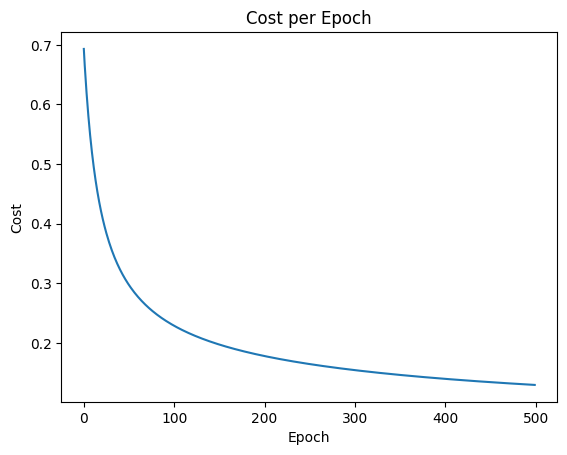

In [254]:
plt.plot(range(len(gdc.cost_per_epoch)), gdc.cost_per_epoch)
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.title("Cost per Epoch")
plt.show()

In [255]:
y_pred = gdc.predict(X_test_norm)
y_pred

array([1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0])

## B) Metrics

In [256]:
metric = Metrics(y_test, y_pred)

In [257]:
print("Accuracy:", metric.accuracy)
print("Precision:", metric.precision)
print("Recall:", metric.recall)
print("F1 Score:", metric.f1_score)

Accuracy: 0.9736842105263158
Precision: 0.9726027397260274
Recall: 0.9861111111111112
F1 Score: 0.9793103448275863


In [258]:
confusion_matrix = metric.confusion_matrix
confusion_matrix

array([[40,  1],
       [ 2, 71]])

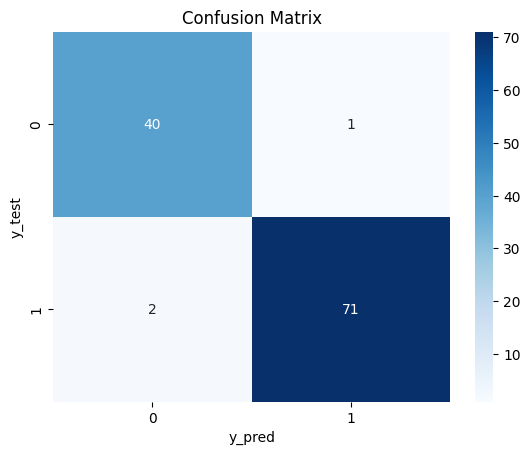

In [259]:
sns.heatmap(confusion_matrix, annot=True, cmap='Blues',
            xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.title('Confusion Matrix')
plt.show()

## C) 10 Kfolds

In [260]:
gdc = GradientDescentClassificator(alpha=0.9, epochs=500, threshold=0.5)

In [261]:
kf = KFold(n_splits=10, shuffle=True, random_state=101)
kf.get_n_splits(X_breast)

accuracy = []
precision = []
recall = []
f1_score = []

for i, (train_index, test_index) in enumerate(kf.split(X_breast)):
    X_train_fold, X_test_fold = X_breast.iloc[train_index], X_breast.iloc[test_index]
    y_train_fold, y_test_fold = y_breast.iloc[train_index], y_breast.iloc[test_index]

    x_max = X_train_fold.max()
    x_min = X_train_fold.min()
    X_train_norm = (X_train_fold - x_min) / (x_max - x_min)
    X_test_norm = (X_test_fold - x_min) / (x_max - x_min)
    gdc.fit(X_train_norm, y_train_fold.values)
    y_pred = gdc.predict(X_test_norm)
    metric = Metrics(y_test_fold, y_pred)

    accuracy.append(metric.accuracy)
    precision.append(metric.precision)
    recall.append(metric.recall)
    f1_score.append(metric.f1_score)

print("\naccuracy:", np.mean(accuracy), "\nSTD:", np.std(accuracy))
print("\nprecision:", np.mean(precision), "\nSTD:", np.std(precision))
print("\nrecall:", np.mean(recall), "\nSTD:", np.std(recall))
print("\nf1_score:", np.mean(f1_score), "\nSTD:", np.std(f1_score))


accuracy: 0.9648809523809524 
STD: 0.019189945479665002

precision: 0.9621912691731433 
STD: 0.029826943309063724

recall: 0.9823027085527085 
STD: 0.02013875778439862

f1_score: 0.9717560168162876 
STD: 0.016691814259410836


# Q2) Iris Decision Surface

In [262]:
df_iris.head()

,petal length (cm),petal width (cm),target
0,1.4,0.2,0
1,1.4,0.2,0
2,1.3,0.2,0
3,1.5,0.2,0
4,1.4,0.2,0


In [263]:
df_iris['target'] = df_iris['target'].replace(2, 1)
df_iris['target'].value_counts()

target
1    100
0     50
Name: count, dtype: int64

In [264]:
X_iris = df_iris.drop(['target'], axis=1)
y_iris = df_iris['target']

gdc = GradientDescentClassificator(alpha=0.7, epochs=100, threshold=0.5)
gdc.fit(X_iris, y_iris.values)

array([-4.04184347,  1.14759595,  1.81072387])

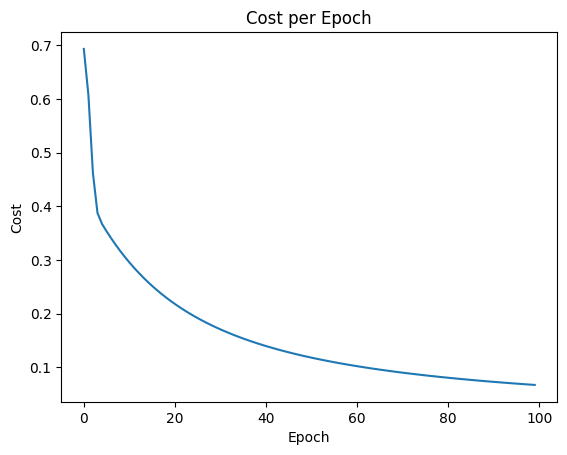

In [265]:
plt.plot(range(len(gdc.cost_per_epoch)), gdc.cost_per_epoch)
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.title("Cost per Epoch")
plt.show()

In [266]:
y_pred = gdc.predict(X_iris)
iris_metrics = Metrics(y_iris, y_pred)
print("Accuracy:", iris_metrics.accuracy)
print("Precision:", iris_metrics.precision)
print("Recall:", iris_metrics.recall)
print("F1 Score:", iris_metrics.f1_score)
print("Confusion Matrix:\n", iris_metrics.confusion_matrix)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[ 50   0]
 [  0 100]]


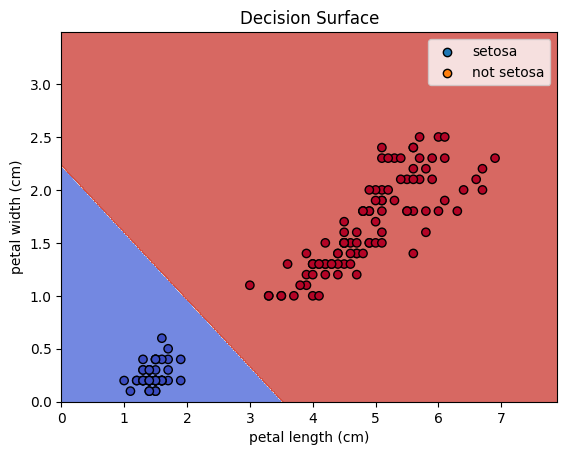

In [267]:
plot_decision_surface(gdc, X_iris, y_iris)